In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# add sim env path
sys.path.append(str(Path("../livingston_simulation").resolve()))
from rl_env import CoherentGoniometerEnv

# DATA_BASE_PATH = "./"
DATA_BASE_PATH = "/w/halld-scshelf2101/home/gjwei/AIOP/sept2025/AIOP-Photon/jupyter_notebooks"
DATA_PATH_2020 = f"{DATA_BASE_PATH}/Spring2020_Merged_goodRuns_nudgesDefined.csv"
DATA_PATH_2023 = f"{DATA_BASE_PATH}/Spring2023_Merged_goodRuns_nudgesDefined.csv"
DATA_PATH_2025 = f"{DATA_BASE_PATH}/Spring2025_Merged_goodRuns_nudgesDefined.csv"
PLOTS_DIR = Path("plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
from livingston_sim import normalize_orientation, infer_nudge_direction_from_sizes, direction_to_pitch_yaw


def get_sign(value: float) -> int:
    if value > 0:
        return 1
    if value < 0:
        return -1
    return 0


class Goniometer:
    def __init__(self, run_period: str):
        self.orientations = ["0/90 PERP", "0/90 PARA", "45/135 PERP", "45/135 PARA"]
        self.current_set_pitch = 0.0
        self.current_set_yaw = 0.0
        self.current_set_roll = 0.0
        self.current_rbv_pitch = 0.0
        self.current_rbv_yaw = 0.0
        self.current_rbv_roll = 0.0
        self.pitch_recent_moves = 0.0
        self.yaw_recent_moves = 0.0
        self.current_diamond_pitch = 0.0
        self.current_diamond_yaw = 0.0
        self.backlash_pitch = 2.1 / 1000.0
        self.backlash_yaw = 4.1 / 1000.0

        if run_period == "2020":
            self.orientation_pitch = [0.39, -0.73, 0.39, 1.81]
            self.orientation_yaw = [1.4, 2.4, 0.73, 0.84]
            self.orientation_roll = [-10.5, -10.5, 34.5, 34.5]
        elif run_period == "2023":
            self.orientation_pitch = [-0.66, 0.33, -1.75, -0.28]
            self.orientation_yaw = [0.17, 1.28, 0.96, 1.06]
            self.orientation_roll = [162, 162, -153, -153]
        elif run_period == "2025":
            self.orientation_pitch = [1.68, 0.59, 0.46, 0.46]
            self.orientation_yaw = [1.52, 1.94, 1.94, 0.49]
            self.orientation_roll = [-16.6, -16.6, 28.4, 28.4]
        else:
            raise ValueError(f"Unsupported run period: {run_period}")

    def change_orientation(self, new_orientation: str) -> None:
        idx = self.orientations.index(new_orientation)
        self.current_set_pitch = self.orientation_pitch[idx]
        self.current_set_yaw = self.orientation_yaw[idx]
        self.current_set_roll = self.orientation_roll[idx]

    def start_your_engines(self, motor: str, signed_nudge_size: float) -> None:
        if motor == "pitch":
            self.current_rbv_pitch += signed_nudge_size
        elif motor == "yaw":
            self.current_rbv_yaw += signed_nudge_size
        elif motor == "roll":
            self.current_rbv_roll += signed_nudge_size

    def change_diamond_angles(self, motor: str, signed_nudge_size: float) -> None:
        if abs(signed_nudge_size) < 0.0001:
            return
        if motor == "pitch":
            if get_sign(signed_nudge_size) * self.backlash_pitch != self.pitch_recent_moves:
                if abs(self.pitch_recent_moves + 2.0 * signed_nudge_size) < self.backlash_pitch:
                    self.pitch_recent_moves += 2.0 * signed_nudge_size
                else:
                    cancelled = (self.backlash_pitch - abs(self.pitch_recent_moves)) / 2.0
                    actual = signed_nudge_size - get_sign(signed_nudge_size) * cancelled
                    self.current_diamond_pitch += actual
                    self.pitch_recent_moves = get_sign(actual) * self.backlash_pitch
            else:
                self.pitch_recent_moves += 2.0 * signed_nudge_size
                self.current_diamond_pitch += signed_nudge_size
                if abs(self.pitch_recent_moves) > self.backlash_pitch:
                    self.pitch_recent_moves = get_sign(self.pitch_recent_moves) * self.backlash_pitch
        elif motor == "yaw":
            if get_sign(signed_nudge_size) * self.backlash_yaw != self.yaw_recent_moves:
                if abs(self.yaw_recent_moves + 2.0 * signed_nudge_size) < self.backlash_yaw:
                    self.yaw_recent_moves += 2.0 * signed_nudge_size
                else:
                    cancelled = (self.backlash_yaw - abs(self.yaw_recent_moves)) / 2.0
                    actual = signed_nudge_size - get_sign(signed_nudge_size) * cancelled
                    self.current_diamond_yaw += actual
                    self.yaw_recent_moves = get_sign(actual) * self.backlash_yaw
            else:
                self.yaw_recent_moves += 2.0 * signed_nudge_size
                self.current_diamond_yaw += signed_nudge_size
                if abs(self.yaw_recent_moves) > self.backlash_yaw:
                    self.yaw_recent_moves = get_sign(self.yaw_recent_moves) * self.backlash_yaw

    def do_nudge(self, motor: str, nudge_size_signed: float) -> None:
        if motor == "pitch":
            self.current_set_pitch += nudge_size_signed
            self.change_diamond_angles(motor, nudge_size_signed)
            self.start_your_engines(motor, nudge_size_signed)
        elif motor == "yaw":
            self.current_set_yaw += nudge_size_signed
            self.change_diamond_angles(motor, nudge_size_signed)
            self.start_your_engines(motor, nudge_size_signed)

    def return_state(self) -> dict:
        return {
            "pitch_set": self.current_set_pitch,
            "yaw_set": self.current_set_yaw,
            "diamond_pitch": self.current_diamond_pitch,
            "diamond_yaw": self.current_diamond_yaw,
        }


def set_orientation_mode(gonio_obj: Goniometer, orientation_mode: int) -> None:
    if orientation_mode == 1:
        gonio_obj.change_orientation("0/90 PERP")
    elif orientation_mode == 2:
        gonio_obj.change_orientation("0/90 PARA")
    elif orientation_mode == 3:
        gonio_obj.change_orientation("45/135 PERP")
    elif orientation_mode == 4:
        gonio_obj.change_orientation("45/135 PARA")
    else:
        raise ValueError(f"Unsupported orientation mode: {orientation_mode}")


class SimEngine:
    def __init__(self, run_period: str, orientation_mode: int):
        self.run_period = run_period
        self.orientation_mode = orientation_mode
        self.orientation_label = normalize_orientation(orientation_mode)
        self.goal_energy = 8600 if run_period == "2020" else 8620 if run_period == "2023" else 8900
        self.nudge_energy_size_pitch = 10.0
        self.nudge_energy_size_yaw = 10.0
        self.e_vals: list[float] = []
        self.times: list[int] = []
        self.pitch_vals: list[float] = []
        self.yaw_vals: list[float] = []
        self.diamond_pitch_vals: list[float] = []
        self.diamond_yaw_vals: list[float] = []
        self.nudge_times: list[int] = []
        self.pitch_diffs: list[float] = []
        self.yaw_diffs: list[float] = []
        self.energy_changes: list[float] = []
        self.last_time = 0
        self.time_delay_on = True
        self.my_goni = Goniometer(run_period)
        set_orientation_mode(self.my_goni, orientation_mode)

    def generate_flat_timestep(self, base_energy: float, noise_size: float) -> float:
        new_time = self.last_time + 1
        current_e = np.random.normal(base_energy, noise_size)
        self.times.append(new_time)
        self.e_vals.append(current_e)
        self.pitch_vals.append(self.my_goni.current_set_pitch)
        self.yaw_vals.append(self.my_goni.current_set_yaw)
        self.diamond_pitch_vals.append(self.my_goni.current_diamond_pitch)
        self.diamond_yaw_vals.append(self.my_goni.current_diamond_yaw)
        self.last_time = new_time
        return base_energy

    def generate_nudge_timestep(self, base_energy: float, noise_size: float, nudge_direction: int, next_nudge_time: int, effectiveness: float = 1.0) -> float:
        base_step = 1.0 / 1000.0
        step_size = abs(nudge_direction * base_step) * effectiveness
        prev_pitch = self.my_goni.current_set_pitch
        prev_yaw = self.my_goni.current_set_yaw
        prev_diamond_pitch = self.my_goni.current_diamond_pitch
        prev_diamond_yaw = self.my_goni.current_diamond_yaw

        pitch_delta, yaw_delta, energy_dir = direction_to_pitch_yaw(self.run_period, self.orientation_label, nudge_direction, step_size)

        if abs(pitch_delta) > 0:
            self.my_goni.do_nudge("pitch", pitch_delta)
        if abs(yaw_delta) > 0:
            self.my_goni.do_nudge("yaw", yaw_delta)

        current_pitch = self.my_goni.current_set_pitch
        current_yaw = self.my_goni.current_set_yaw
        current_diamond_pitch = self.my_goni.current_diamond_pitch
        current_diamond_yaw = self.my_goni.current_diamond_yaw

        pitch_diff = current_pitch - prev_pitch
        yaw_diff = current_yaw - prev_yaw
        energy_change = energy_dir * ((pitch_diff ** 2 * self.nudge_energy_size_pitch ** 2 + yaw_diff ** 2 * self.nudge_energy_size_yaw ** 2) ** 0.5) / 0.001

        new_time = self.last_time + 1
        self.nudge_times.append(new_time)
        self.pitch_diffs.append(pitch_diff)
        self.yaw_diffs.append(yaw_diff)
        self.energy_changes.append(energy_change)

        if self.time_delay_on:
            delay_end = min(new_time + np.random.choice([8, 9, 10]), next_nudge_time)
            delay_steps = max(0, delay_end - new_time)
            for _ in range(delay_steps):
                current_e = np.random.normal(base_energy, noise_size)
                self.times.append(new_time)
                self.e_vals.append(current_e)
                self.pitch_vals.append(current_pitch)
                self.yaw_vals.append(current_yaw)
                self.diamond_pitch_vals.append(current_diamond_pitch)
                self.diamond_yaw_vals.append(current_diamond_yaw)
                new_time += 1

        base_energy += energy_change
        current_e = np.random.normal(base_energy, noise_size)
        self.times.append(new_time)
        self.e_vals.append(current_e)
        self.pitch_vals.append(current_pitch)
        self.yaw_vals.append(current_yaw)
        self.diamond_pitch_vals.append(current_diamond_pitch)
        self.diamond_yaw_vals.append(current_diamond_yaw)
        self.last_time = new_time
        return base_energy

    def generate_timeseries(self, num_seconds: int, input_energy: float, noise_size: float, nudge_times: list[int], nudge_directions: list[int], nudge_effectiveness: list[float] | None = None) -> None:
        current_energy = input_energy
        if nudge_effectiveness is None:
            nudge_effectiveness = [1.0] * len(nudge_times)
        for idx, nudge_time in enumerate(nudge_times):
            while self.last_time < nudge_time - 1:
                current_energy = self.generate_flat_timestep(current_energy, noise_size)
            next_nudge_time = nudge_times[idx + 1] if idx + 1 < len(nudge_times) else num_seconds + 100
            current_energy = self.generate_nudge_timestep(current_energy, noise_size, nudge_directions[idx], next_nudge_time, nudge_effectiveness[idx])
        while self.last_time < num_seconds:
            current_energy = self.generate_flat_timestep(current_energy, noise_size)


def build_nudge_schedule(df_run: pd.DataFrame, run_number: int, orientation_mode: int, run_period: str):
    df_nudges = df_run[(df_run["RunNumber"] == run_number) & (df_run["NudgeOccurred"])]
    if df_nudges.empty:
        raise ValueError(f"No nudges found for run {run_number}")
    nudge_times: list[int] = []
    nudge_directions: list[int] = []
    nudge_effectiveness: list[float] = []
    orientation_label = normalize_orientation(orientation_mode)
    for nudge_no in sorted(df_nudges["NudgeNumber"].unique()):
        df_this = df_nudges[df_nudges["NudgeNumber"] == nudge_no]
        time_stamp = int(df_this["TimeStamp"].min())
        pitch_size = float(df_this["NudgePitchSize"].mode()[0])
        yaw_size = float(df_this["NudgeYawSize"].mode()[0])
        eff = float(df_this["NudgeEffectiveness"].mode()[0])
        eff = 0.0 if np.isnan(eff) else max(0.0, eff)
        dir_val = infer_nudge_direction_from_sizes(orientation_label, pitch_size, yaw_size)
        nudge_times.append(time_stamp)
        nudge_directions.append(dir_val)
        nudge_effectiveness.append(eff)
    return nudge_times, nudge_directions, nudge_effectiveness


def compute_peak_series_from_env(sim: SimEngine, orientation_index: int, base_peak: float, run_period: str | None = None) -> list[float]:
    run_period = run_period or getattr(sim, 'run_period', '2020')
    env = CoherentGoniometerEnv(
        beam_energy_E0=11600.0,
        coherent_edge_Ei=base_peak,
        base_peak_position=base_peak,
        orientation_index=orientation_index,
        run_period=run_period,
        pitch_step_deg=1e-3,
        yaw_step_deg=1e-3,
        dose_per_step=0.0,
        max_steps=max(1, len(sim.times) + 5),
    )
    env.reset()
    peaks: list[float] = []
    prev_pitch = sim.pitch_vals[0] if sim.pitch_vals else 0.0
    prev_yaw = sim.yaw_vals[0] if sim.yaw_vals else 0.0
    delta_c, peak = env.sim.step(dpitch_deg=0.0, dyaw_deg=0.0, delta_dose=0.0)
    peaks.append(peak)
    for i in range(1, len(sim.pitch_vals)):
        dp = sim.pitch_vals[i] - prev_pitch
        dy = sim.yaw_vals[i] - prev_yaw
        prev_pitch = sim.pitch_vals[i]
        prev_yaw = sim.yaw_vals[i]
        delta_c, peak = env.sim.step(dpitch_deg=dp, dyaw_deg=dy, delta_dose=0.0)
        peaks.append(peak)
    return peaks


def plot_sim_and_data(sim: SimEngine, df_run: pd.DataFrame, run_number: int, time_window: tuple[int, int], energy_window: tuple[int, int], save_path: str | None = None, peak_series: list[float] | None = None):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(sim.times, sim.e_vals, label="Simulated Cobrem Edge", color="magenta", alpha=0.7)

    if peak_series is not None and len(peak_series) >= len(sim.times):
        ax.plot(sim.times, peak_series[: len(sim.times)], label="RL env peak", color="green", alpha=0.8)

    minE, maxE, expectedE = 8550, 8650, sim.goal_energy
    if 80000 < run_number < 130000:
        minE, maxE, expectedE = 8520, 8720, 8620
    elif run_number > 130000:
        minE, maxE, expectedE = 8800, 9000, 8900

    df_vis = df_run[(df_run["RunNumber"] == run_number) & (df_run["CBREM:ENERGY"] > minE) & (df_run["CBREM:ENERGY"] < maxE)]
    if time_window:
        df_vis = df_vis[(df_vis["TimeStamp"] >= time_window[0]) & (df_vis["TimeStamp"] <= time_window[1])]

    ax.plot(df_vis["TimeStamp"], df_vis["CBREM:ENERGY"], color="navy", label="Cobrem Edge (data)", alpha=0.8)

    for time_idx, energy_change in enumerate(sim.energy_changes):
        nudge_time = sim.nudge_times[time_idx]
        pitch_diff = sim.pitch_diffs[time_idx]
        yaw_diff = sim.yaw_diffs[time_idx]
        total_nudge_angle = (pitch_diff ** 2 + yaw_diff ** 2) ** 0.5
        linewidth = max(0.5, abs(total_nudge_angle) * 1000)
        color = "blue" if energy_change > 0 else "red" if energy_change < 0 else "gray"
        ax.axvline(nudge_time, linestyle="--", color=color, alpha=0.5, linewidth=linewidth)

    ax.set_ylabel(r"$E_\gamma$ [MeV]")
    ax.axhline(8600, color="black", linestyle="--", linewidth=1, label="Nominal 8600")
    ax.axhspan(expectedE - 10, expectedE + 10, color="green", alpha=0.08, label="Goal ±10 MeV")
    ax.set_ylim(sim.goal_energy - energy_window[0], sim.goal_energy + energy_window[1])
    ax.set_xlim(time_window)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.set_xlabel("Time (s)")
    orientation_labels = {1: '0/90 PERP', 2: '0/90 PARA', 3: '45/135 PERP', 4: '45/135 PARA'}
    orientation_text = orientation_labels.get(getattr(sim, 'orientation_mode', 1), 'unknown')
    title_text = f'Run {run_number} ({sim.run_period}) – {orientation_text}'
    ax.set_title(title_text)
    ax.legend(loc="upper right")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    return fig, ax


def run_plot(df_run: pd.DataFrame, config: dict):
    run_number = config['run_number']
    orientation_mode = config['orientation_mode']
    run_period = config['run_period']
    input_energy = config['input_energy']
    base_peak = config['base_peak']
    time_window = config['time_window']
    energy_window = config['energy_window']
    noise_size = config.get('noise_size', 1)

    nudge_times, nudge_directions, nudge_effectiveness = build_nudge_schedule(df_run, run_number, orientation_mode, run_period)

    sim = SimEngine(run_period, orientation_mode)
    sim.generate_timeseries(
        num_seconds=time_window[1],
        input_energy=input_energy,
        noise_size=noise_size,
        nudge_times=nudge_times,
        nudge_directions=nudge_directions,
        nudge_effectiveness=nudge_effectiveness,
    )

    peak_series = compute_peak_series_from_env(sim, orientation_index=orientation_mode, base_peak=base_peak, run_period=run_period)

    plot_path = PLOTS_DIR / f'simulated_run_{run_number}_top_only.pdf'
    fig, ax = plot_sim_and_data(
        sim=sim,
        df_run=df_run,
        run_number=run_number,
        time_window=time_window,
        energy_window=energy_window,
        save_path=str(plot_path),
        peak_series=peak_series,
    )
    return fig, ax, plot_path


/scratch/davidl/ipykernel_1514462/1650476393.py:1: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2020 = pd.read_csv(DATA_PATH_2020)
/scratch/davidl/ipykernel_1514462/1650476393.py:3: DtypeWarning: Columns (33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv(DATA_PATH_2023)
/scratch/davidl/ipykernel_1514462/1650476393.py:5: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2025 = pd.read_csv(DATA_PATH_2025)


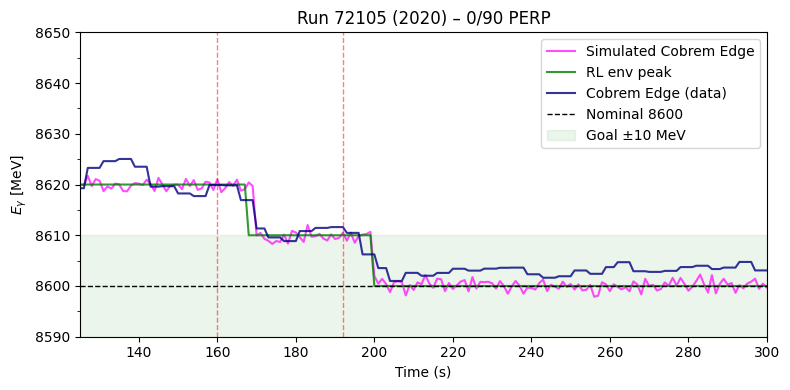

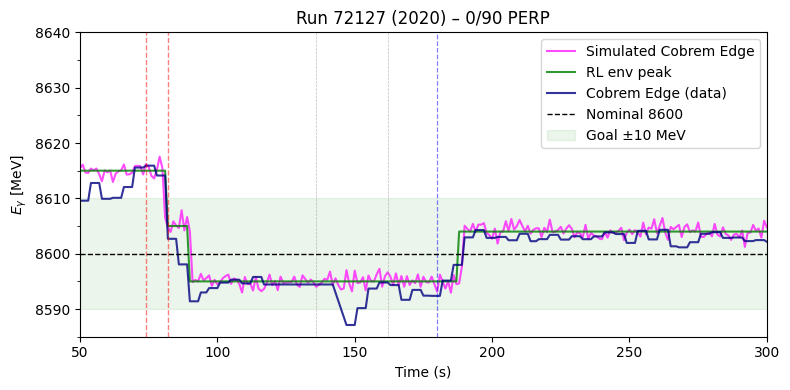

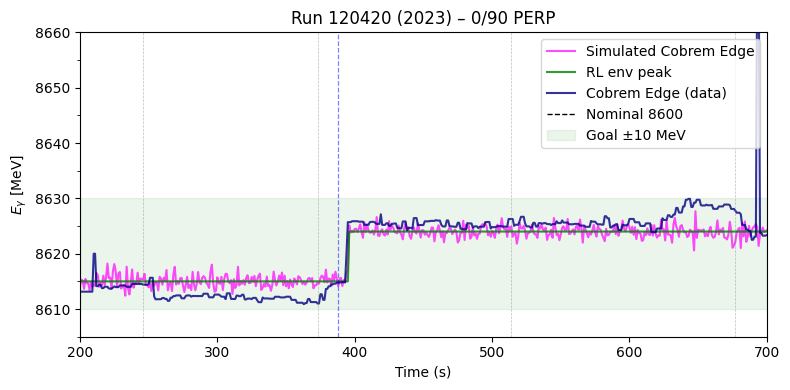

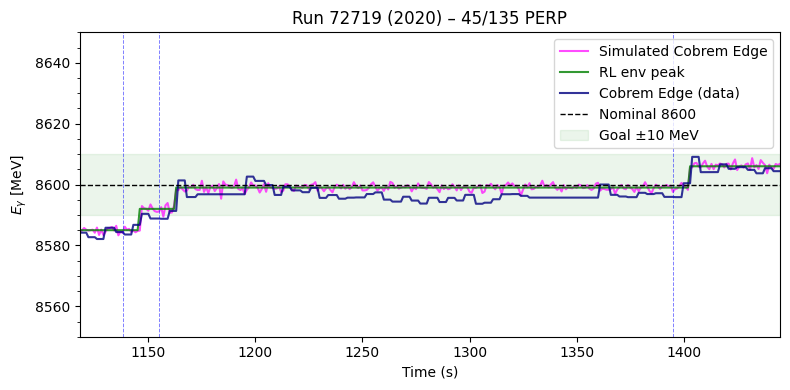

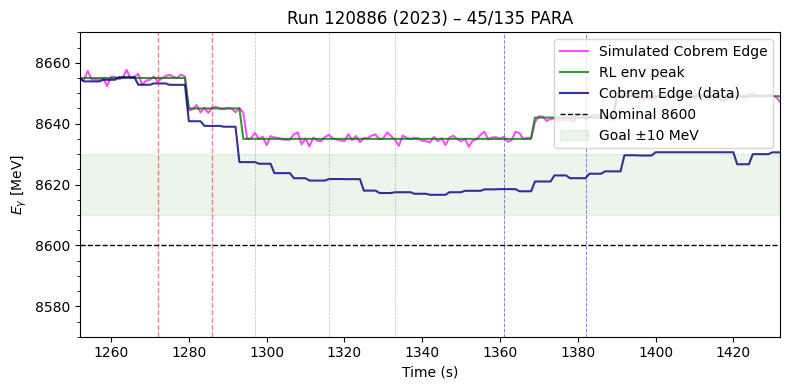

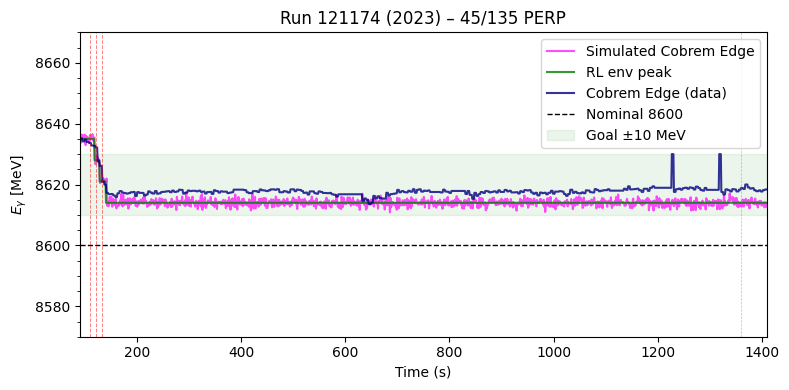

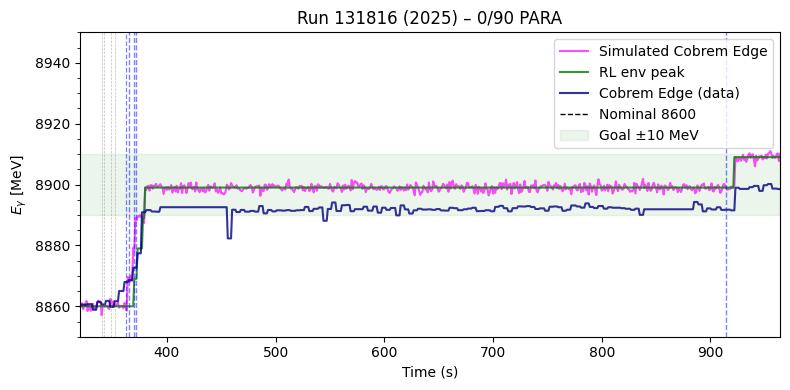

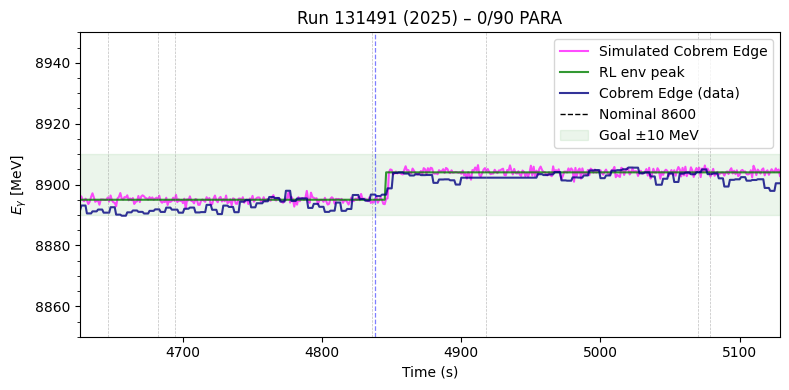

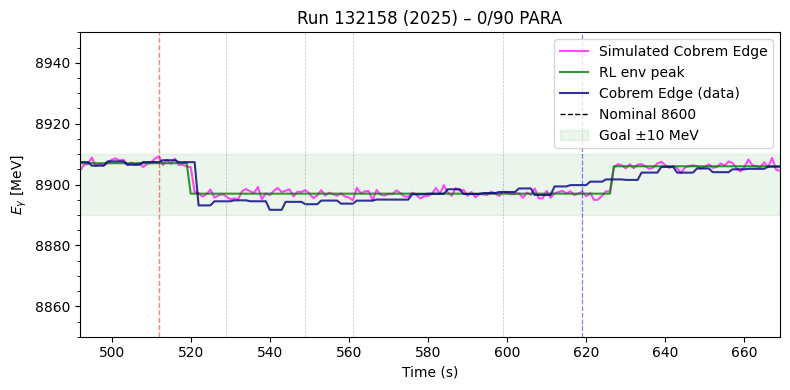

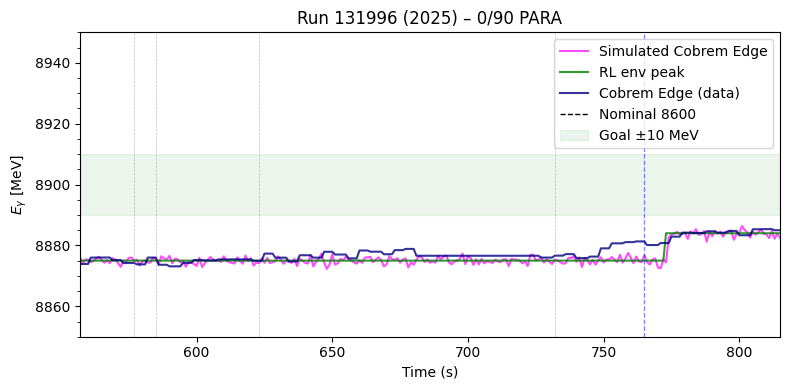

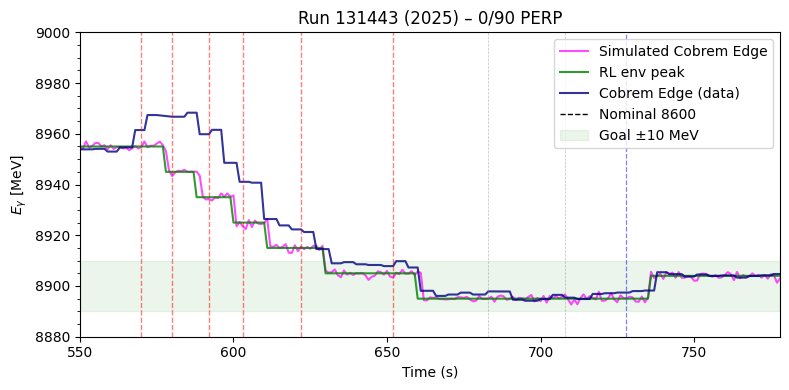

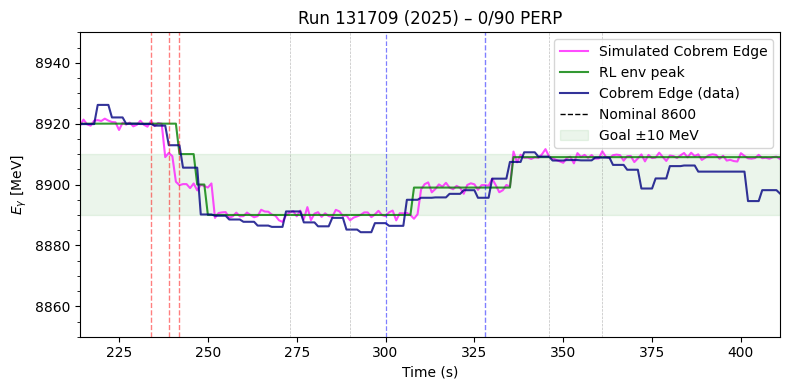

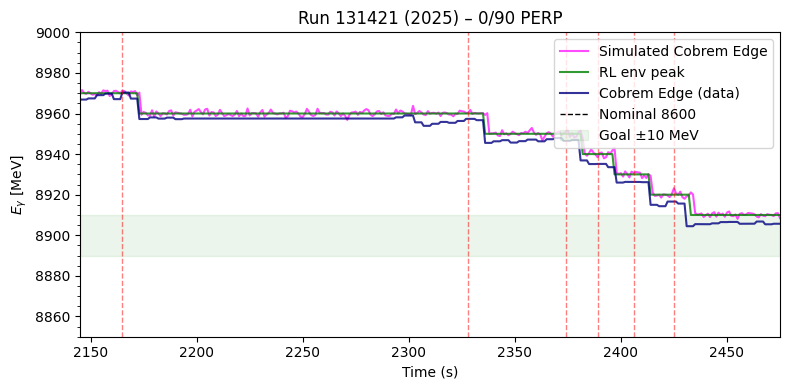

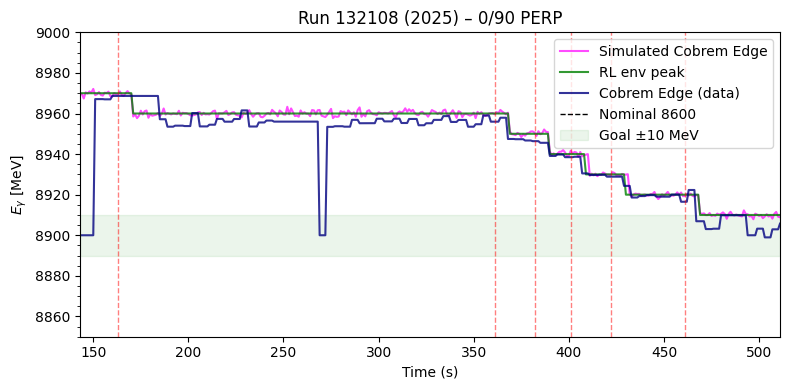

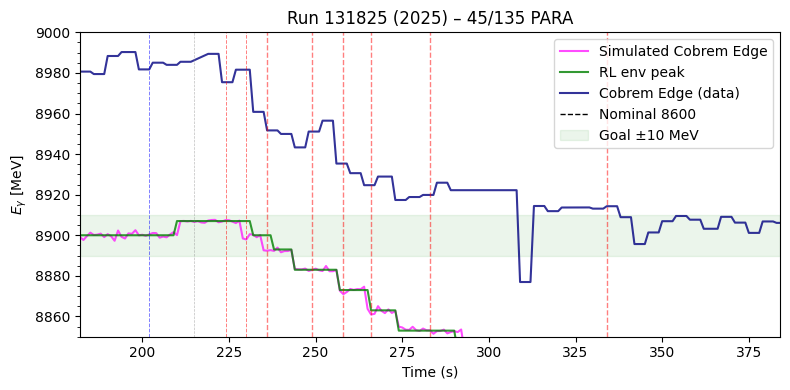

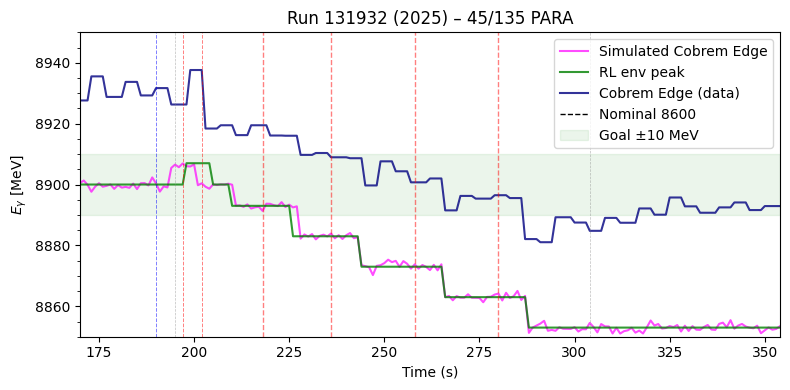

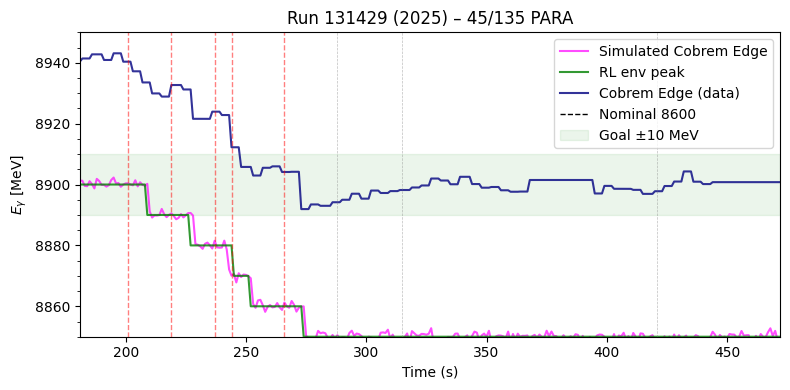

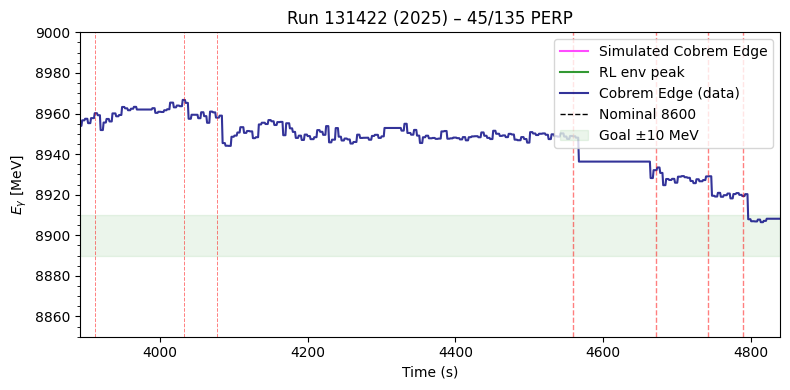

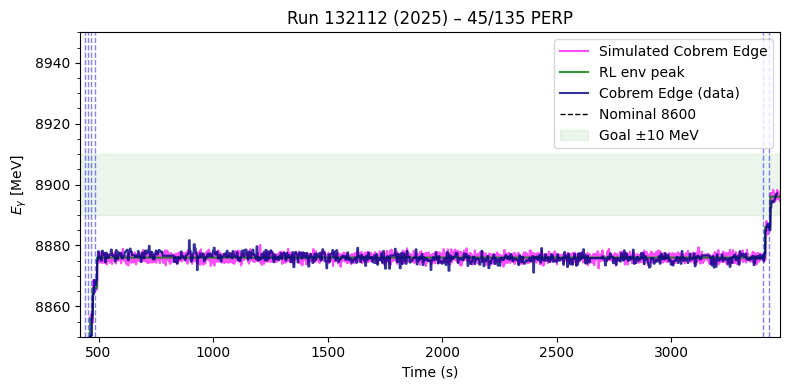

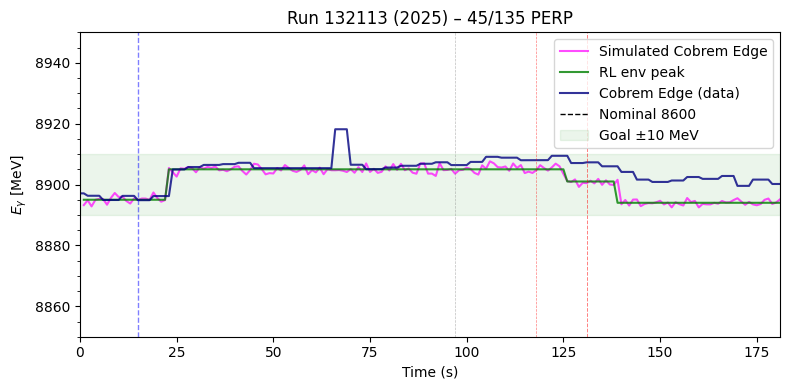

[PosixPath('plots/simulated_run_72105_top_only.pdf'),
 PosixPath('plots/simulated_run_72127_top_only.pdf'),
 PosixPath('plots/simulated_run_120420_top_only.pdf'),
 PosixPath('plots/simulated_run_72719_top_only.pdf'),
 PosixPath('plots/simulated_run_120886_top_only.pdf'),
 PosixPath('plots/simulated_run_121174_top_only.pdf'),
 PosixPath('plots/simulated_run_131816_top_only.pdf'),
 PosixPath('plots/simulated_run_131491_top_only.pdf'),
 PosixPath('plots/simulated_run_132158_top_only.pdf'),
 PosixPath('plots/simulated_run_131996_top_only.pdf'),
 PosixPath('plots/simulated_run_131443_top_only.pdf'),
 PosixPath('plots/simulated_run_131709_top_only.pdf'),
 PosixPath('plots/simulated_run_131421_top_only.pdf'),
 PosixPath('plots/simulated_run_132108_top_only.pdf'),
 PosixPath('plots/simulated_run_131825_top_only.pdf'),
 PosixPath('plots/simulated_run_131932_top_only.pdf'),
 PosixPath('plots/simulated_run_131429_top_only.pdf'),
 PosixPath('plots/simulated_run_131422_top_only.pdf'),
 PosixPath('p

In [ ]:
df_2020 = pd.read_csv(DATA_PATH_2020)
df_2020_good = df_2020[(df_2020['goodRun']) & (df_2020['RunHasNudge']) & (df_2020['TotalNudges_thisRun'] >= 1)]
df_2023 = pd.read_csv(DATA_PATH_2023)
df_2023_good = df_2023[(df_2023['goodRun']) & (df_2023['RunHasNudge']) & (df_2023['TotalNudges_thisRun'] >= 1)]
df_2025 = pd.read_csv(DATA_PATH_2025)
df_2025_good = df_2025[(df_2025['goodRun']) & (df_2025['RunHasNudge']) & (df_2025['TotalNudges_thisRun'] >= 1)]

df_by_period = {"2020": df_2020_good, "2023": df_2023_good, "2025": df_2025_good}

run_configs = [
    {"run_number": 72105, "orientation_mode": 1, "run_period": "2020", "input_energy": 8620, "base_peak": 8620.0, "time_window": (125, 300), "energy_window": (10, 50)},
    {"run_number": 72127, "orientation_mode": 1, "run_period": "2020", "input_energy": 8615, "base_peak": 8615.0, "time_window": (50, 300), "energy_window": (15, 40)},
    {"run_number": 120420, "orientation_mode": 1, "run_period": "2023", "input_energy": 8615, "base_peak": 8615.0, "time_window": (200, 700), "energy_window": (15, 40)},

    # {'run_number': 72659, 'orientation_mode': 3, 'run_period': '2020', 'input_energy': 8620.0, 'base_peak': 8620.0, 'time_window': (77, 311), 'energy_window': (50, 50)},
    {'run_number': 72719, 'orientation_mode': 3, 'run_period': '2020', 'input_energy': 8585.0, 'base_peak': 8585.0, 'time_window': (1118, 1445), 'energy_window': (50, 50)},
    # {'run_number': 120420, 'orientation_mode': 1, 'run_period': '2023', 'input_energy': 8615.0, 'base_peak': 8615.0, 'time_window': (226, 727), 'energy_window': (50, 50)},
    # {'run_number': 120753, 'orientation_mode': 4, 'run_period': '2023', 'input_energy': 8615.0, 'base_peak': 8615.0, 'time_window': (551, 856), 'energy_window': (50, 50)},
    # {'run_number': 120768, 'orientation_mode': 4, 'run_period': '2023', 'input_energy': 8615.0, 'base_peak': 8615.0, 'time_window': (651, 982), 'energy_window': (50, 50)},
    # {'run_number': 120837, 'orientation_mode': 4, 'run_period': '2023', 'input_energy': 8615.0, 'base_peak': 8615.0, 'time_window': (126, 568), 'energy_window': (50, 50)},
    # {'run_number': 120850, 'orientation_mode': 4, 'run_period': '2023', 'input_energy': 8615.0, 'base_peak': 8615.0, 'time_window': (122, 527), 'energy_window': (50, 50)},
    {'run_number': 120886, 'orientation_mode': 4, 'run_period': '2023', 'input_energy': 8655.0, 'base_peak': 8655.0, 'time_window': (1252, 1432), 'energy_window': (50, 50)},
    {'run_number': 121174, 'orientation_mode': 3, 'run_period': '2023', 'input_energy': 8635.0, 'base_peak': 8635.0, 'time_window': (91, 1409), 'energy_window': (50, 50)},
    # {'run_number': 131407, 'orientation_mode': 2, 'run_period': '2025', 'input_energy': 8900.0, 'base_peak': 8900.0, 'time_window': (349, 1057), 'energy_window': (50, 50)},
    {'run_number': 131816, 'orientation_mode': 2, 'run_period': '2025', 'input_energy': 8860.0, 'base_peak': 8860.0, 'time_window': (320, 964), 'energy_window': (50, 50)},
    {'run_number': 131491, 'orientation_mode': 2, 'run_period': '2025', 'input_energy': 8895.0, 'base_peak': 8895.0, 'time_window': (4626, 5129), 'energy_window': (50, 50)},
    {'run_number': 132158, 'orientation_mode': 2, 'run_period': '2025', 'input_energy': 8907.0, 'base_peak': 8907.0, 'time_window': (492, 669), 'energy_window': (50, 50)},
    {'run_number': 131996, 'orientation_mode': 2, 'run_period': '2025', 'input_energy': 8875.0, 'base_peak': 8875.0, 'time_window': (557, 815), 'energy_window': (50, 50)},
    {'run_number': 131443, 'orientation_mode': 1, 'run_period': '2025', 'input_energy': 8955.0, 'base_peak': 8955.0, 'time_window': (550, 778), 'energy_window': (20, 100)},
    {'run_number': 131709, 'orientation_mode': 1, 'run_period': '2025', 'input_energy': 8920.0, 'base_peak': 8920.0, 'time_window': (214, 411), 'energy_window': (50, 50)},
    {'run_number': 131421, 'orientation_mode': 1, 'run_period': '2025', 'input_energy': 8970.0, 'base_peak': 8970.0, 'time_window': (2145, 2475), 'energy_window': (50, 100)},
    {'run_number': 132108, 'orientation_mode': 1, 'run_period': '2025', 'input_energy': 8970.0, 'base_peak': 8970.0, 'time_window': (143, 511), 'energy_window': (50, 100)},
    # {'run_number': 131968, 'orientation_mode': 1, 'run_period': '2025', 'input_energy': 8900.0, 'base_peak': 8900.0, 'time_window': (183, 354), 'energy_window': (50, 50)},
    {'run_number': 131825, 'orientation_mode': 4, 'run_period': '2025', 'input_energy': 8985.0, 'base_peak': 8985.0, 'time_window': (182, 384), 'energy_window': (50, 100)},
    {'run_number': 131932, 'orientation_mode': 4, 'run_period': '2025', 'input_energy': 8930.0, 'base_peak': 8930.0, 'time_window': (170, 354), 'energy_window': (50, 50)},
    # {'run_number': 131974, 'orientation_mode': 4, 'run_period': '2025', 'input_energy': 8900.0, 'base_peak': 8900.0, 'time_window': (332, 513), 'energy_window': (50, 50)},
    {'run_number': 131429, 'orientation_mode': 4, 'run_period': '2025', 'input_energy': 8943.0, 'base_peak': 8943.0, 'time_window': (181, 472), 'energy_window': (50, 50)},
    # {'run_number': 132004, 'orientation_mode': 4, 'run_period': '2025', 'input_energy': 8900.0, 'base_peak': 8900.0, 'time_window': (527, 804), 'energy_window': (50, 50)},
    # {'run_number': 132088, 'orientation_mode': 3, 'run_period': '2025', 'input_energy': 8900.0, 'base_peak': 8900.0, 'time_window': (1538, 6953), 'energy_window': (50, 50)},
    {'run_number': 131422, 'orientation_mode': 3, 'run_period': '2025', 'input_energy': 8960.0, 'base_peak': 8960.0, 'time_window': (3892, 4839), 'energy_window': (50, 100)},
    {'run_number': 132112, 'orientation_mode': 3, 'run_period': '2025', 'input_energy': 8826.0, 'base_peak': 8826.0, 'time_window': (419, 3475), 'energy_window': (50, 50)},
    {'run_number': 132113, 'orientation_mode': 3, 'run_period': '2025', 'input_energy': 8895.0, 'base_peak': 8895.0, 'time_window': (0, 181), 'energy_window': (50, 50)},
    # {'run_number': 131658, 'orientation_mode': 3, 'run_period': '2025', 'input_energy': 8900.0, 'base_peak': 8900.0, 'time_window': (309, 713), 'energy_window': (50, 50)}
    ]

plots = []
for cfg in run_configs:
    df_this = df_by_period.get(cfg['run_period'], df_2020_good)
    fig, ax, path = run_plot(df_this, cfg)
    plots.append(path)
    plt.show()

plots